# Gravity circulation with CPR preconditioner
This example demonstrates a more complex gravity driven instability. The
problem is a bit larger than the Gravity segregation example, and is
therefore set up using the high level API that automatically sets up an
iterative linear solver with a constrained pressure residual (CPR)
preconditioner and automatic timestepping.

The high level API uses the more low level `Jutul` API seen in the other
examples under the hood and makes more complex problems easy to set up. The
same data structures and functions are used, allowing for deep customization
if the defaults are not appropriate.

In [1]:
using JutulDarcy
using Jutul
using GLMakie
cmap = :seismic
nx = nz = 100;

## Define the domain

In [2]:
D = 10.0
g = CartesianMesh((nx, 1, nz), (D, 1.0, D))
domain = reservoir_domain(g)

DataDomain wrapping CartesianMesh (3D) with 100x1x100=10000 cells with 17 data fields added:
  10000 Cells
    :permeability => 10000 Vector{Float64}
    :porosity => 10000 Vector{Float64}
    :rock_thermal_conductivity => 10000 Vector{Float64}
    :fluid_thermal_conductivity => 10000 Vector{Float64}
    :rock_density => 10000 Vector{Float64}
    :cell_centroids => 3×10000 Matrix{Float64}
    :volumes => 10000 Vector{Float64}
  19800 Faces
    :neighbors => 2×19800 Matrix{Int64}
    :areas => 19800 Vector{Float64}
    :normals => 3×19800 Matrix{Float64}
    :face_centroids => 3×19800 Matrix{Float64}
  39600 HalfFaces
    :half_face_cells => 39600 Vector{Int64}
    :half_face_faces => 39600 Vector{Int64}
  20400 BoundaryFaces
    :boundary_areas => 20400 Vector{Float64}
    :boundary_centroids => 3×20400 Matrix{Float64}
    :boundary_normals => 3×20400 Matrix{Float64}
    :boundary_neighbors => 20400 Vector{Int64}


## Set up model and properties

In [3]:
Darcy, bar, kg, meter, day = si_units(:darcy, :bar, :kilogram, :meter, :day)
p0 = 100*bar
rhoLS = 1000.0*kg/meter^3 # Definition of fluid phases
rhoVS = 500.0*kg/meter^3
cl, cv = 1e-5/bar, 1e-4/bar
L, V = LiquidPhase(), VaporPhase()
sys = ImmiscibleSystem([L, V])
model, parameters = setup_reservoir_model(domain, sys)
density = ConstantCompressibilityDensities(sys, p0, [rhoLS, rhoVS], [cl, cv]) # Replace density with a lighter pair
replace_variables!(model, PhaseMassDensities = density);
kr = BrooksCoreyRelativePermeabilities(sys, [2.0, 3.0])
replace_variables!(model, RelativePermeabilities = kr)

MultiModel with 1 models and 0 cross-terms. 20000 equations and 20000 degrees of freedom.

  models:
    1) Reservoir (20000x20000)
       ImmiscibleSystem with LiquidPhase, VaporPhase
       ∈ MinimalTPFATopology (10000 cells, 19800 faces)

Model storage will be optimized for compilation performance.


### Define initial saturation
Set the left part of the domain to be filled by the vapor phase and the heavy
liquid phase in the remainder. To do this, we grab the cell centroids in the x
direction from the domain, reshape them to the structured mesh we are working
on and define the liquid saturation from there.

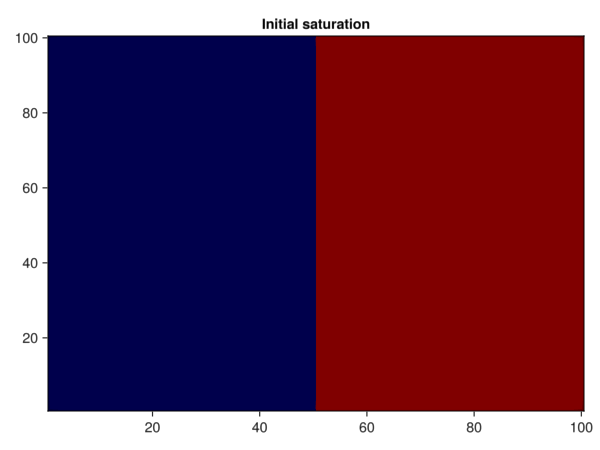

In [4]:
c = domain[:cell_centroids]
x = reshape(c[1, :], nx, nz)

sL = zeros(nx, nz)
plane = D/2.0
for i in 1:nx
    for j = 1:nz
        X = x[i, j]
        sL[i, j] = clamp(Float64(X > plane), 0, 1)
    end
end
heatmap(sL, colormap = cmap, axis = (title = "Initial saturation",))

### Set up initial state

In [5]:
sL = vec(sL)'
sV = 1 .- sL
s0 = vcat(sV, sL)
state0 = setup_reservoir_state(model, Pressure = p0, Saturations = s0)

Dict{Any, Any} with 1 entry:
  :Reservoir => Dict{Symbol, Any}(:PhaseMassMobilities=>[0.0 0.0 … 0.0 0.0; 0.0…

### Set the viscosity of the phases
By default, viscosity is a parameter and can be set per-phase and per cell.

In [6]:
μ = parameters[:Reservoir][:PhaseViscosities]
@. μ[1, :] = 1e-3
@. μ[2, :] = 5e-3

10000-element view(::Matrix{Float64}, 2, :) with eltype Float64:
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 ⋮
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005

Convert time-steps from days to seconds

In [7]:
timesteps = repeat([10.0*3600*24], 20)
_, states, = simulate_reservoir(state0, model, timesteps, parameters = parameters, info_level = 1);

Jutul: Simulating 28 weeks, 4 days as 20 report steps
Step  1/20: Solving start to 1 week, 3 days, Δt = 1 week, 3 days 
Step  2/20: Solving 1 week, 3 days to 2 weeks, 6 days, Δt = 1 week, 3 days 
Step  3/20: Solving 2 weeks, 6 days to 4 weeks, 2 days, Δt = 1 week, 3 days 
Step  4/20: Solving 4 weeks, 2 days to 5 weeks, 5 days, Δt = 1 week, 3 days 
Step  5/20: Solving 5 weeks, 5 days to 7 weeks, 1 day, Δt = 1 week, 3 days 
Step  6/20: Solving 7 weeks, 1 day to 8 weeks, 4 days, Δt = 1 week, 3 days 
Step  7/20: Solving 8 weeks, 4 days to 10 weeks, Δt = 1 week, 3 days 
Step  8/20: Solving 10 weeks to 11 weeks, 3 days, Δt = 1 week, 3 days 
Step  9/20: Solving 11 weeks, 3 days to 12 weeks, 6 days, Δt = 1 week, 3 days 
Step 10/20: Solving 12 weeks, 6 days to 14 weeks, 2 days, Δt = 1 week, 3 days 
Step 11/20: Solving 14 weeks, 2 days to 15 weeks, 5 days, Δt = 1 week, 3 days 
Step 12/20: Solving 15 weeks, 5 days to 17 weeks, 1 day, Δt = 1 week, 3 days 
Step 13/20: Solving 17 weeks, 1 day to 18 

## Plot results
Plot initial saturation

In [8]:
tmp = reshape(state0[:Reservoir][:Saturations][1, :], nx, nz)
f = Figure()
ax = Axis(f[1, 1], title = "Before")
heatmap!(ax, tmp, colormap = cmap)

MakieCore.Heatmap{Tuple{Vector{Float32}, Vector{Float32}, Matrix{Float32}}}

Plot intermediate saturation

In [9]:
tmp = reshape(states[length(states) ÷ 2][:Saturations][1, :], nx, nz)
ax = Axis(f[1, 2], title = "Half way")
hm = heatmap!(ax, tmp, colormap = cmap)

MakieCore.Heatmap{Tuple{Vector{Float32}, Vector{Float32}, Matrix{Float32}}}

Plot final saturation

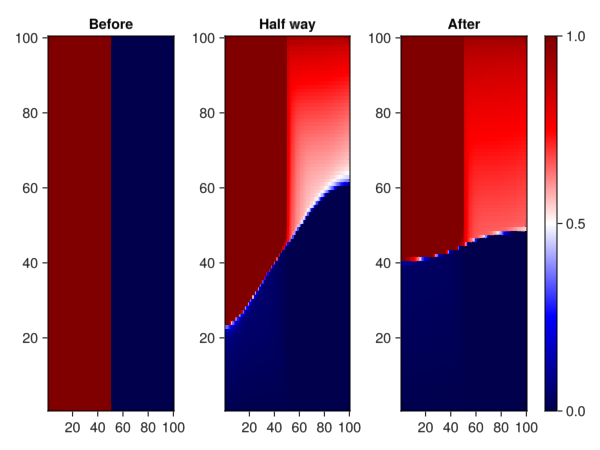

In [10]:
tmp = reshape(states[end][:Saturations][1, :], nx, nz)
ax = Axis(f[1, 3], title = "After")
hm = heatmap!(ax, tmp, colormap = cmap)
Colorbar(f[1, 4], hm)
f

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*